# Multidimensional Motif Discovery

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/TDAmeritrade/stumpy/main?filepath=notebooks/Tutorial_Multidimensional_Motif_Discovery.ipynb)

## Finding a Motif in Multidimensional Time Series Data with MSTUMP

This tutorial utilizes the main takeaways from the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) research paper and requires STUMPY v1.6.1 or newer. Also, the word “dimensionality” is overloaded for multi-dimensional time series since it is often used to refer to both the number of time series and to the number of data points in a subsequence. For clarity, we restrict our use of "dimensions" to refer only to the number of time series and not to the number of data points.

Previously, we had introduced a concept called [time series motifs](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), which are conserved patterns found within a 1-dimensional time series, $T$, that can be discovered by computing its [matrix profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) using STUMPY. This process of computing a matrix profile with one time series is commonly known as a "self-join" since the subsequences within time series $T$ are only being compared with itself. Since the first 1-dimensional motif discovery algorithm was introduced in 2002, a lot of effort has been made to generalize motif-finding to the multi-dimensional case but producing multi-dimensional matrix profiles are computationally expensive and so extra care must be taken to minimize the added time complexity. Also, while it may be tempting to find motifs in all available dimensions (i.e., a motif must exist in all dimensions and occur simultaneously), it has been shown that this rarely produces meaningful motifs except in the most contrived situations. Instead, given a set of time series dimensions, we should filter them down to a subset of "useful" dimensions before assigning a subsequence as a motif. For example, take a look at this motion capture of a boxer throwing some punches:

In [1]:
from IPython.display import IFrame

IFrame(width="560", height="315", src="https://www.youtube.com/embed/2CQttFf2OhU")

If we strictly focus on the boxer’s right arm in both cases, the two punches are almost identical. The position of the right shoulder, right elbow, and right hand (a three dimensional time series) are virtually the indistinguishable. So, identifying this punching motif is relatively straightforward when we limit ourselves to only a subset of all of the available body movement dimensions. However, if we incorporate the full set of motion capture markers from all of the limbs (i.e., increasing the number of dimensions from three), the differences captured by the left arm and the subtle noise in the footwork actually drowns out the the similarity of the right arm motions, making the previous punching motif impossible to find. This example demonstrates how classic multidimensional motif discovery algorithms are likely to fail since they try to use all of the available dimensions. So, not only do we need an efficient algorithm for computing the multi-dimensional matrix profile but we also need to establish an informed approach to guide us in selecting the relevant subset of dimensions that are to be used in identifying multi-dimensional motifs.

In this tutorial, we will explain precisely what a multi-dimensional matrix profile is and then we'll learn how to compute it using the `mstump` function (i.e., "multi-dimensional STUMP") by exploring a simple toy dataset. To conclude, we'll see if we can identify a meaningful sub-dimensional motif (i.e., that only uses a subset of dimensions) in this multi-dimensional time series data.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Loading and Visualizing the Toy Data

In this example data, we have a 3-dimensional time series labeled `T1`, `T2`, and `T3`. Can you spot where the motif is? Does that motif exist in one, two, or all three dimensions?

In [3]:
df = pd.read_csv("https://zenodo.org/record/4328047/files/toy.csv?download=1")
df.head()

,T1,T2,T3
0,0.565117,0.637180,0.741822
1,0.493513,0.629415,0.739731
2,0.469350,0.539220,0.718757
3,0.444100,0.577670,0.730169
4,0.373008,0.570180,0.752406


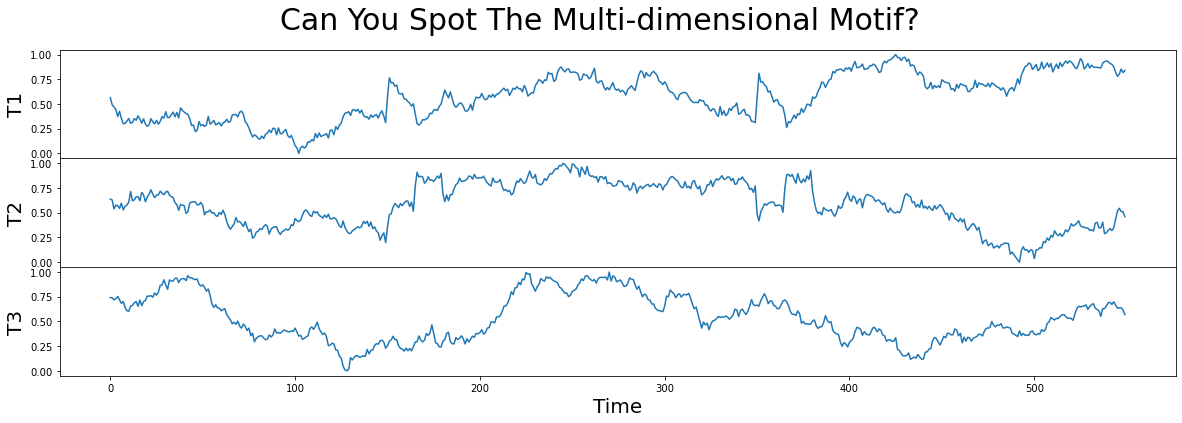

In [4]:
fig, axs = plt.subplots(df.shape[1], sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Multi-dimensional Motif?', fontsize='30')

for i in range(df.shape[1]):
    axs[i].set_ylabel(f'T{i + 1}', fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(df[f'T{i + 1}'])
    
plt.show()

## A Quick 1-Dimensional Exploration

Before diving into a multi-dimensional matrix profile analysis, let's take a naive approach and simply run the classic 1-dimensional motif discovery algorithm, `stumpy.stump`, on each of the dimensions independently (using a window size of `m = 30`) and extract 1-dimensional motif pairs:

In [5]:
m = 30
mps = {}  # Store the 1-dimensional matrix profiles
motifs_idx = {}  # Store the index locations for each pair of 1-dimensional motifs (i.e., the index location of two smallest matrix profile values within each dimension)
for dim_name in df.columns:
    mps[dim_name] = stumpy.stump(df[dim_name], m)
    motif_distance = np.round(mps[dim_name][:, 0].min(), 1)
    print(f"The motif pair matrix profile value in {dim_name} is {motif_distance}")
    motifs_idx[dim_name] = np.argsort(mps[dim_name][:, 0])[:2]

The motif pair matrix profile value in T1 is 1.1
The motif pair matrix profile value in T2 is 1.0
The motif pair matrix profile value in T3 is 1.1


And when we plot the raw times series again (below) along with their independently discovered motifs (thick red lines), we can correctly match the visually obvious motif pairs in `T1` and `T2` starting near locations `150` and `350` (dotted vertical lines). Notice that these two motifs aren't perfectly aligned in time (i.e., they aren't occurring simultaneously) but they are reasonably close to each and their motif pair values are `1.1` and `1.0`, respectively. This is a great start!

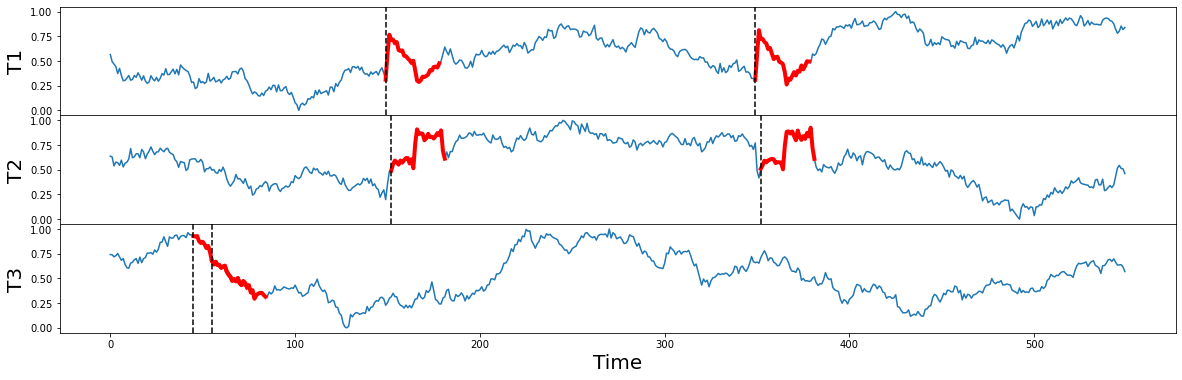

In [6]:
fig, axs = plt.subplots(len(mps), sharex=True, gridspec_kw={'hspace': 0})

for i, dim_name in enumerate(list(mps.keys())):
    axs[i].set_ylabel(dim_name, fontsize='20')
    axs[i].plot(df[dim_name])
    axs[i].set_xlabel('Time', fontsize ='20')
    for idx in motifs_idx[dim_name]:
        axs[i].plot(df[dim_name].iloc[idx:idx+m], c='red', linewidth=4)
        axs[i].axvline(x=idx, linestyle="dashed", c='black')
    
plt.show()

However, when we examine `T3`, its motif pair are overlapping each other starting near position `50` (dotted vertical lines) and they are relatively far away from the motifs discovered in `T1` and `T2`. Oh, no!

In fact, `T3` is actually a "random walk" time series that was purposely included in this set as a decoy and, unlike `T1` and `T2`, `T3` does not contain any conserved behavior whatsoever despite the fact that the distance between its motif pair is `1.1`, a red herring. This illustrates a few important points:

1. if there are additional irrelevant dimensions (i.e., `T3`), you will do about as well as random chance at discovering multi-dimensional motifs if you don't ignore/dismiss those distracting dimensions
2. if you suspect that there are motifs in only a subset of the time series, how do you know which dimensions are involved, or how do you even know how many dimensions are relevant?
3. doing motif search on all dimensions is almost always guaranteed to produce meaningless results, even if a subset of dimensions has clear and unambiguous motifs (like our example above)

A quick survey of all current multi-dimensional motif discovery algorithms in the literature (see Section II in [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf)) reveals that they are slow, approximate, and brittle to irrelevant dimensions. In contrast, what we need is an algorithm that is fast, exact, and robust to hundreds of irrelevant dimensions and to spurious data. And this is where `stumpy.mstump` can help!

## Multi-dimensional Matrix Profiles

There is no substitution for the multi-dimensional matrix profile definitions provided in the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) paper (see Section III and Section IV) and so we refer the reader to this quintessential resource for a detailed walkthrough. However, to develop some basic intuition, we'll share an oversimplified description for computing a multi-dimensional matrix profile but know that the `stumpy.mstump` function provides a highly efficient, accurate, and scalable variant to the naive explanation provided here.

First and foremost, we must start by dispelling a common misconception regarding multi-dimensional matrix profiles: 

> Multi-dimensional matrix profiles are <b>not</b> 1-dimensional matrix profiles stacked one on top of each other!

So, what is a multi-dimensional matrix profile? To answer this question, let's step away from our toy data example for a minute and suppose that we have a "multi-dimensional time series", $T = [T1, T2, T3, T4]$, which has $d = 4$ dimensions and length $n = 7$ (i.e., there are seven data points or "positions" within each dimension). Then, $T$ simply has shape $d\times n$ (or $4\times 7$). If we choose a window size, $m = 3$, then we can define the $i^{th}$ "multi-dimensional subsequence" as a continuous subset of the values from $T$ of length $m$ starting from position $i$ that has an overall shape of $d\times m$ (or $4\times 3$). You can think of each multi-dimensional subsequence as a rectangular slice of $T$ and $T$ can only have exactly $l = n - m + 1$ multi-dimensional subsequences. In our example, $T$ has exactly $l = 5$ multi-dimensional subsequences (i.e., we can incrementally slide a $4\times 3$-shaped rectangle across the length of $T$ only $5$ times before we reach the end of $T$) and, for the $i^{th}$ multi-dimensional subsequence, we can iterate over each of its dimensions independently and compute an aggregated "multi-dimensional distance profile" (i.e., four [1-dimensional distance profiles](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Distance-Profile---Pairwise-Euclidean-Distances) stacked one on top of each other). Essentially, the $i^{th}$ multi-dimensional distance profile has shape $d\times l$ (or $4\times 5$) and gives you the pairwise distances between the $i^{th}$ multi-dimensional subsequence and all other possible multi-dimensional subsequences within $T$. 

Recall that our ultimate goal is to output something called the "multi-dimensional matrix profile" (and its corresponding "multi-dimensional matrix profile indices"), which has an overall shape of $d\times l$ (i.e., one set of $d$ values for each of the $l$ multi-dimensional subsequences). As it turns out, the values in the $i^{th}$ column of the multi-dimensional matrix profile is directly derived from the $i^{th}$ multi-dimensional distance profile. Continuing with our example, let's illustrate this process using the fictitious array below to represent a typical multi-dimensional distance profile for the $i^{th}$ multi-dimensional subsequence:

```
ith_distance_profile = np.ndarray([[0.4, 0.2, 0.6, 0.5, 0.2, 0.1, 0.9],
                                   [0.7, 0.0, 0.2, 0.6, 0.1, 0.2, 0.9],
                                   [0.6, 0.7, 0.1, 0.5, 0.8, 0.3, 0.4],
                                   [0.7, 0.4, 0.3, 0.1, 0.2, 0.1, 0.7]])
```

With this, we can now identify the set of $d$ values that form the $i^{th}$ column vector of the multi-dimensional matrix profile with shape $d\times 1$ (or $4\times 1$). The value for the first dimension is found by extracting the smallest value in each column of the `ith_distance_profile` and then returning the minimum value in the reduced set. Then, the value for the second dimension is found by extracting the two smallest values in each column of the `ith_distance_profile`, averaging these two values, and then returning the minimum averaged value in the reduced set. Finally, the value for the $k^{th}$ out of $d$ dimensions is found by extracting the $k$ smallest values in each column of the `ith_distance_profile`, averaging these $k$ values, and then returning the minimum averaged value in the reduced set. A naive algorithm might look something like this:

```
ith_matrix_profile = np.full(d, np.inf)
ith_indices = np.full(d, -1, dtype=np.int64)

for k in range(1, d + 1):
    smallest_k = np.partition(ith_distance_profile, k, axis=0)[:k]  # retrieves the smallest k values in each column
    averaged_smallest_k = smallest_k.mean(axis=0)
    min_val = averaged_smallest_k.min()
    if min_val < ith_matrix_profile[k - 1]:
        ith_matrix_profile[k - 1] = min_val
        ith_indices[k - 1] = averaged_smallest_k.argmin()
```

Therefore, by simply advancing the $i^{th}$ multi-dimensional subsequence along the entire length of $T$ and then computing its corresponding $i^{th}$ multi-dimensional matrix profile (and indices), we can easily populate the full multi-dimensional matrix profile and multi-dimensional matrix profile indices. And, hopefully, you'd agree with our initial statement that:

> multi-dimensional matrix profiles are <b>not</b> 1-dimensional matrix profiles stacked one on top of each other!

But then what exactly does each dimension of the multi-dimensional matrix profile tell us? Essentially, the $k^{th}$ dimension (or row) of the multi-dimensional matrix profile stores the distance between each subsequence and its nearest neighbor (the distance is computed using a $k$-dimensional distance function as we saw above). We should point out that, for the $k^{th}$ dimension of the multi-dimensional matrix profile, only a subset of time series dimensions (i.e., $k$ out of $d$ dimensions) are selected and this subset of chosen dimensions can change as you vary either the $i^{th}$ multi-dimensional subsequence and/or $k$. 

Now that we have a better understanding of what a multi-dimensional matrix profile is, let's go ahead and compute it by simply calling the `stumpy.mstump` function on our original toy dataset:

In [7]:
mps, indices = stumpy.mstump(df, m)

Consequently, the "$k$-dimensional motif" can be found by locating the lowest values in the corresponding $k$-dimensional matrix profile, `mps`:

In [8]:
motifs_idx = np.argsort(mps, axis=1)[:, 0]

and the index location of the "$k$-dimensional nearest neighbor" can be found by:

In [9]:
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

Finally, we can plot the $k$-dimensional matrix profile (orange lines) for all possible values of $k$ (i.e., `P1`, `P2`, and `P3`) alongside the original time series data (blue lines):

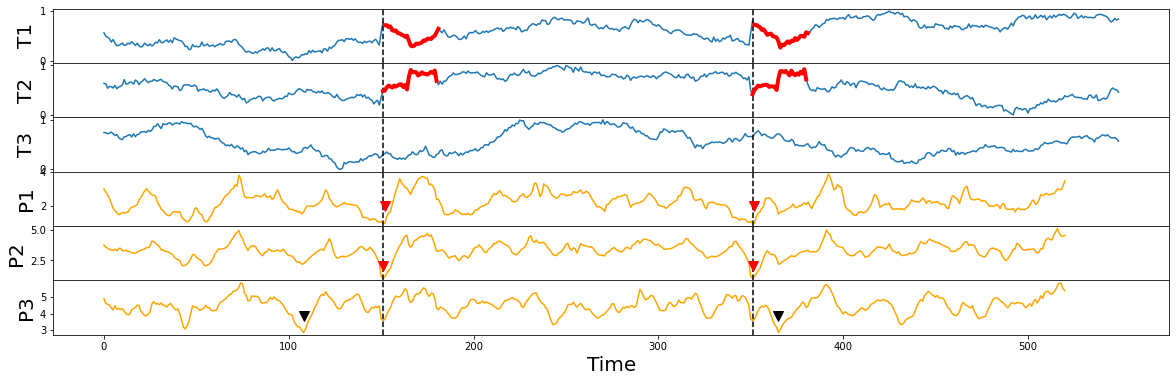

In [10]:
fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    
    if dim_name != 'T3':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

Notice that the (implanted) semantically meaningful motif (thick red lines) can be spotted visually by inspecting the locations of the lowest points (red arrowheads) in either the `P1` or `P2` matrix profiles but the `P3` case has identified the motif (black arrowheads) in an effectively random location, which further reinforces the point that we had made earlier:

> if there are additional irrelevant dimensions (i.e., `T3`), you will do about as well as random chance at discovering multi-dimensional motifs if you don't ignore/dismiss those distracting dimensions

Additionally, it may seem counterintuitive, but as demonstrated above, the lower dimensional motif(s) may or may not necessarily be a subset of the higher dimensional motif, since the lower dimensional motif pair could be closer than any subset of dimensions in the higher dimensional motif pair. In general, this is a subtle but important point to keep in mind.

## Finding $k$ - The Naive Approach

So then how do we choose the "right" $k$? One straightforward approach is to turn this into a classic elbow/knee finding problem by plotting the minimum matrix profile value in each dimension against $k$ and then you look for the "turning point" (i.e., the point of maximum curvature):

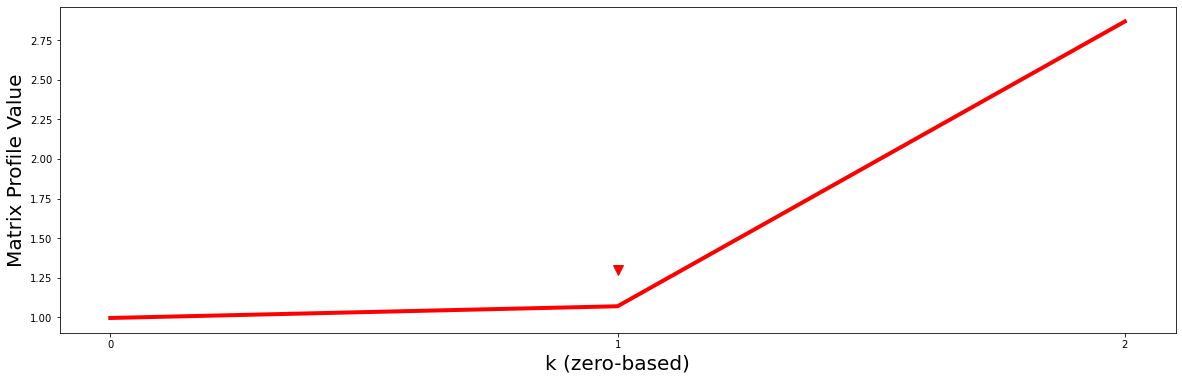

In [11]:
plt.plot(mps[range(mps.shape[0]), motifs_idx], c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Matrix Profile Value', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.plot(1, 1.3, marker="v", markersize=10, color='red')
plt.show()

Notice that the red line curves up sharply right after $k = 1$ (red arrowhead) like a "hockey stick" and so, naturally, we should choose $P2$ and its motif as the best motif out of all possible $k$-dimensional motifs. 

## Finding $k$ - A Minimum Description Length Approach

Unfortunately, the naive elbow-finding method above isn't robust and cannot be easily automated so the authors of the [Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf) paper recommend computing something called the "minimum description length" (MDL), which is a fancy way of asking, "for a given motif pair, if you're only allowed to use $k$ dimensions from one of the multi-dimensional subsequence to compress its nearest neighbor's $k$th-dimensional subsequence, what is resulting compression size?" In other words, how similar is the $k$-dimensional motif pair? When we answer this question by leveraging MDL, we'll find that a $k$-dimensional motif pair with high similarity will allow for the greatest amount of information/data compression and the number of bits, or "bit size", will usually be lower than their peers. So, if we use the MDL framework to calculate the bit size for each of the `k` dimensions for a given motif pair, then all we need to do to find `k` is to look for the global minima. For our example, lets compute the MDL using `stumpy.mdl`: 

In [12]:
mdls, subspaces = stumpy.mdl(df, m, motifs_idx, nn_idx)

Here, `mdls` contains the bit sizes for each $k$ and `subspaces` is a list that tells you exactly which subset of all dimensions were used to compute the $k$th MDL value. Now, let's visualize the MDL results:

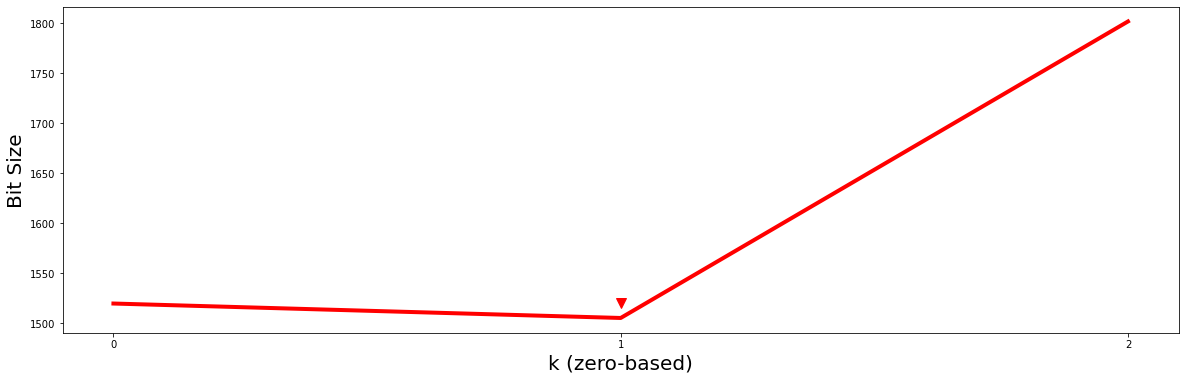

In [13]:
plt.plot(np.arange(len(mdls)), mdls, c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Bit Size', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.plot(1, 1520, marker="v", markersize=10, color='red')
plt.show()

Essentially, by looking for the value of $k$ with the smallest bit size, we should choose $P2$ and its motif as the best motif out of all possible $k$-dimensional motifs. Additionally, the subset of dimensions that were selected for this $k = 1$ motif (i.e., subspaces[k]) can be easily retrieved from `subspaces`:

In [14]:
k = np.argmin(mdls)
print(df.columns[subspaces[k]])

Index(['T2', 'T1'], dtype='object')


So, consistent with what we discussed above, columns `T2` and `T1` contain the best motif! To really drive home this point, let's add a few more random walk decoys to our toy data set, randomly shuffle the order of the columns, and compare the smallest $k$-dimensional matrix profile values again: 

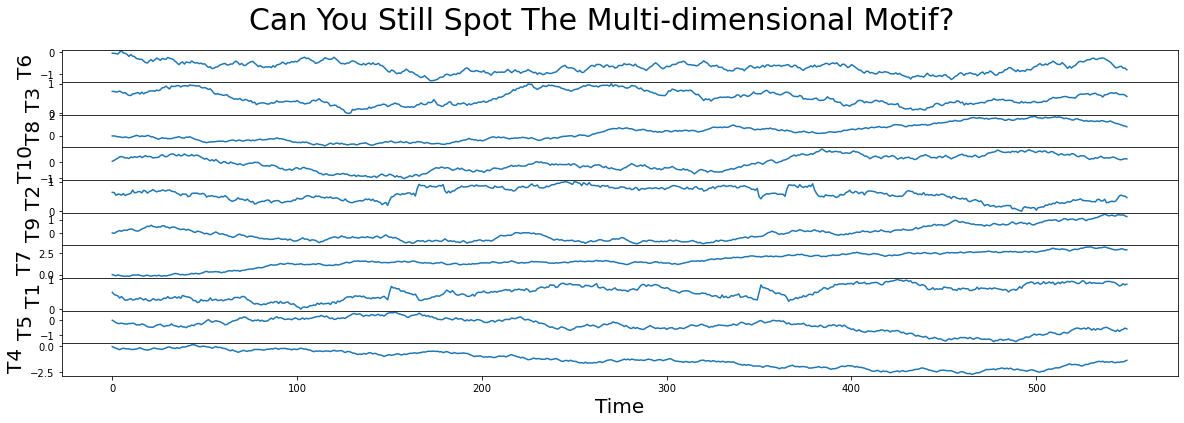

In [15]:
for i in range(4, 11):
    df[f'T{i}'] = np.random.uniform(0.1, -0.1, size=df.shape[0]).cumsum()
    
df = df.sample(frac=1, axis="columns")  # Randomly shuffle the columns

fig, axs = plt.subplots(df.shape[1], sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Still Spot The Multi-dimensional Motif?', fontsize='30')

for i, colname in enumerate(df.columns):
    axs[i].set_ylabel(colname, fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(df[colname])
    
plt.show()

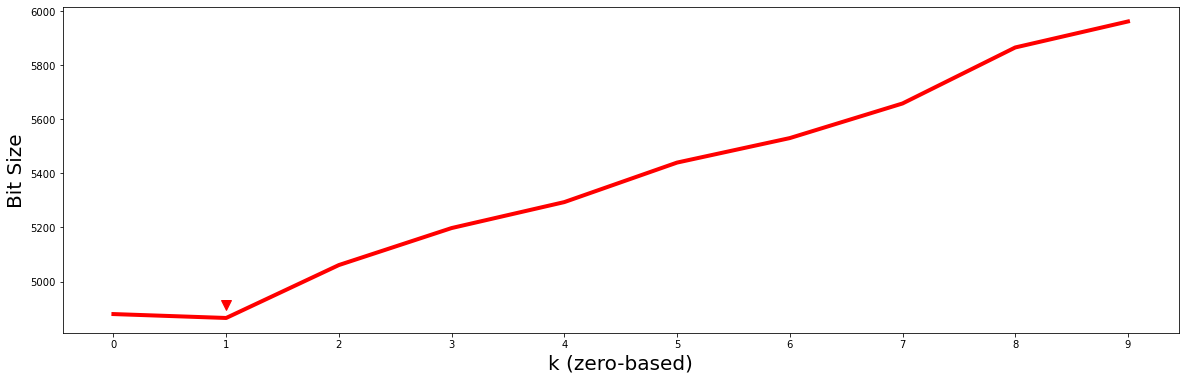

In [16]:
mps, indices = stumpy.mstump(df, m)
motifs_idx = np.argsort(mps, axis=1)[:, 0]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]
mdls, subspaces = stumpy.mdl(df, m, motifs_idx, nn_idx)
k = np.argmin(mdls)
plt.plot(np.arange(len(mdls)), mdls, c='red', linewidth='4')
plt.xlabel('k (zero-based)', fontsize='20')
plt.ylabel('Bit Size', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.plot(k, 1.01 * mdls[k], marker="v", markersize=10, color='red')
plt.show()

Even with 7 additional decoys added to the mix, the minimum MDL bit size still occurs at $k = 1$ (red arrowhead) and so we should continue to choose $P2$ and its motif as the best motif out of all possible $k$-dimensional motifs. Again, although the columns of our data have been randomly shuffled around, the corresponding subspace can be easily retrieved via:

In [17]:
k = np.argmin(mdls)
print(df.columns[subspaces[k]])

Index(['T2', 'T1'], dtype='object')


## Matrix Profile Subspace

There are times when you may find the need to compute the (singular) "$k$-dimensional matrix profile subspace" without computing MDL (e.g., if you already have a specific value of $k$ in mind due to some prior knowledge or constraint). Luckily, the STUMPY convenience function, `stumpy.subspace`, can help us with this!

To use `stumpy.subspace`, we simply pass in:

1. the multi-dimensional time series, `df`, used to compute the multi-dimensional matrix profile
2. the window size, `m`, used to compute the multi-dimensional matrix profile
3. the indices for the $k^{th}$-dimensional motif pair, `motifs_idx[k]` and `nn_idx[k]` (from `indices[np.arange(len(motifs_idx)), motifs_idx[k]]`)
4. the desired (zero-based) dimension, `k`

In [18]:
k = 1
subspace = stumpy.subspace(df, m, motifs_idx[k], nn_idx[k], k)

print(f"For k = {k}, the {k + 1}-dimensional subspace includes subsequences from {df.columns[subspace].values}")

For k = 1, the 2-dimensional subspace includes subsequences from ['T2' 'T1']


So, after computing the multi-dimensional matrix profile using `mstump` and selecting the second dimension (i.e., $k = 1$), according to the $k$-dimensional subspace, the motif should be extracted from `T2` and `T1` out of all of the possible time series dimensions.

## Bonus Section

### MSTUMPED - Distributed MSTUMP

Dependent upon the total number of dimensions and the length of your time series dat, it may be computationally expensive to produce the multi-dimensional matrix profile. Thus,  you can overcome this by trying `mstumped`, a distributed and parallel implementation of `mstump` that depends on [Dask distributed](https://distributed.dask.org/en/latest/):


```
import stumpy
from dask.distributed import Client

dask_client = Client()

mps, indices = stumpy.mstumped(dask_client, df, m)  # Note that a dask client is needed
```

### Constrained Search

There may be situations where you want to find the best motif on $k$ dimensions but you want to explicitly "include" or "exclude" a given subset of dimensions. In the trivial exclusion case, one just needs to omit the undesired time series dimensions before calling `mstump`:

```
mps, indices = stumpy.mstump(df[df.columns.difference(['T3'])], m)  # This excludes the `T3` dimension
```

However, in the case of inclusion, the user may have specific time series dimensions that they'd always want to be included or prioritized in the multi-dimensional matrix profile output and so you can provide a list of (zero-based) dimensions as an parameter:

```
mps, indices = stumpy.mstump(df, m, include=[0, 1])
motifs_idx = np.argsort(mps, axis=1)[:, 0]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx[k])
```

So, in this example where we've instructed `mstump` to `include=[0, 1]` (i.e., `T1` and `T2`), when $k\ge 1$, the $k^{th}$ dimensional matrix profile subspace:

```
k = 2
S = stumpy.subspace(df, m, motifs_idx[k], nn_idx[k], k, include=[0, 1])
```

will always include `T1` and `T2`. Similarly, $k\lt 1$ will include either `T1` or `T2`.

Finally, instead of searching for motifs, it is also possible to have `mstump` search for discords by simply passing in the `discords=True` parameter:

```
mps, indices = stumpy.mstump(df, m, discords=True)
discords_idx = np.argsort(-mps, axis=1)[:, 0]
nn_idx = indices[np.arange(len(discords_idx)), discords_idx[k])
k = 2
S = stumpy.subspace(df, m, discords_idx[k], nn_idx[k], k, discords=True)
```

Instead of returning the smallest average distance, this returns the largest average distance across $k$ dimensions. However, note that we use `-mps` (i.e., multiply `mps` by `-1.0`) before sorting in order to focus on discords. This ability to return discords is unique to STUMPY and was not published in the original paper. 

<div class="alert alert-block alert-danger">
<b>Warning:</b> When you use `discord=True` to compute the multi-dimensional matrix profile, you've generated a "discord-specific" multi-dimensional matrix profile and, therefore, you must set `discords=True` everywhere. In other words, you can never use this "discord-specific" multi-dimensional matrix profile to search for motifs. Instead, you must re-compute a "motif-specific" multi-dimensional matrix profile (i.e., by seting `discords=False` everywhere).
</div>

Also note that it is possible to include specific dimensions and search for discords at the same time:


```
mps, indices = stumpy.mstump(df, m, include=[0, 1], discords=True)
discords_idx = np.argsort(-mps, axis=1)[:, 0]
nn_idx = indices[np.arange(len(discords_idx)), discords_idx[k])
k = 2
S = stumpy.subspace(df, m, discords_idx[k], nn_idx[k], k, include=[0, 1], discords=True)
```

In this case, the dimensions listed in `include` are honored first and then all subsequent dimensions are sorted by their largest average distance across $k$ dimensions.

## Summary

And that's it! You've just learned the basics of how to analyze multi-dimensional time series data using `stumpy.mstump` (or `stumpy.mstumped`). Happy coding!

## Resources

[Matrix Profile VI](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf)

[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)